In [1]:
from objVAE import objVAE, fg, bg
import numpy as np
import glob
import tifffile
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import skimage
import torch
import h5py

In [2]:
filepath = r'C:\Users\GU\HoltraDev\Holtra\fields.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

In [3]:
import numpy as np
patch_size = 64
import skimage
import scipy.io as sio

fields = arrays["fields"]

training_images=skimage.measure.block_reduce(fields, (1,2,2), np.mean)

# filtered=np.array([skimage.filters.gaussian(training_images[...,i],sigma=4) for i in range(training_images.shape[-1])])
# training_images=np.array([training_images[...,i]-filtered[i] for i in range(len(filtered))])

training_images = torch.tensor(np.array([training_images[i,...,np.newaxis] for i in range(training_images.shape[0])])).float()
# make channel first
#real_images = torch.real(training_images)
#imag_images = torch.imag(training_images)

#training_images = torch.stack((real_images, imag_images), axis=-1).float()
training_images = training_images.permute(0, 3, 1, 2)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(1, 2, 3), keepdim=True) / 3
#train, test = torch.utils.data.random_split(tensors, [40000, 9917])



In [4]:
training_images.shape

torch.Size([195, 1, 480, 360])

In [5]:

# create dataloaders
train_loader = torch.utils.data.DataLoader(training_images, batch_size=8, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)



In [6]:
import matplotlib.pyplot as plt

def plot(model, test_loader):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    recon, presence, bg, fg, xy, z_bg, kl_bg, kl_fg = model(x)
    
    
#     print(presence)
#     xy = xy.view(1, -1, x.shape[2], x.shape[3])
    alpha = presence[0].detach().cpu().numpy()
    xy = xy.detach().cpu().numpy()

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[0, :, 1], xy[0, :, 0], alpha=alpha, marker="+", s=80, c="r")
    
    plt.title("Input image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")

    
#     plt.subplot(2, 2, 3)
#     plt.imshow(
#         bg[0, 0, :, :].detach().cpu().numpy(),
#         vmin=x[0, 0, :, :].min(),
#         vmax=x[0, 0, :, :].max(),
#         cmap="gray",
#     )
#     plt.title("Background pred")
    
#     plt.subplot(2, 2, 4)
#     plt.imshow(
#         fg[0, 0, :, :].detach().cpu().numpy(),
#         vmin=x[0, 0, :, :].min(),
#         vmax=x[0, 0, :, :].max(),
#         cmap="gray",
#     )
#     plt.title("Foreground pred")

    return plt

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'none',
    'decoder_depth': 5,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'none',
    'encoder_depth': 4,
    'hidden_dim': 12,
    'position_dim': 100
}

fg_params = {
    'decoder_activation': 'mish',
    'decoder_feature_size': 56,
    'decoder_norm': 'none',
    'decoder_norm_first': True,
    'decoder_num_layers': 4,
    'glimpse_size': 16,
    'latent_dim': 24,
    'position_embedding': 'radial',
    'position_prediction_scale': 1,
    'position_representation_scale': 1,
    'position_embedding_dim': 1,
    'num_entities': 48,
    'encoder_depth': 3,
    'topk_select_method': "max"
}

fg_model = fg.objFG(**fg_params)
bg_model = bg.objBG(in_channels=1,image_size=64, **bg_params)
model = objVAE.objVAE(bg_model=bg_model, fg_model=fg_model, beta=1e-9, learning_rate=8e-4)



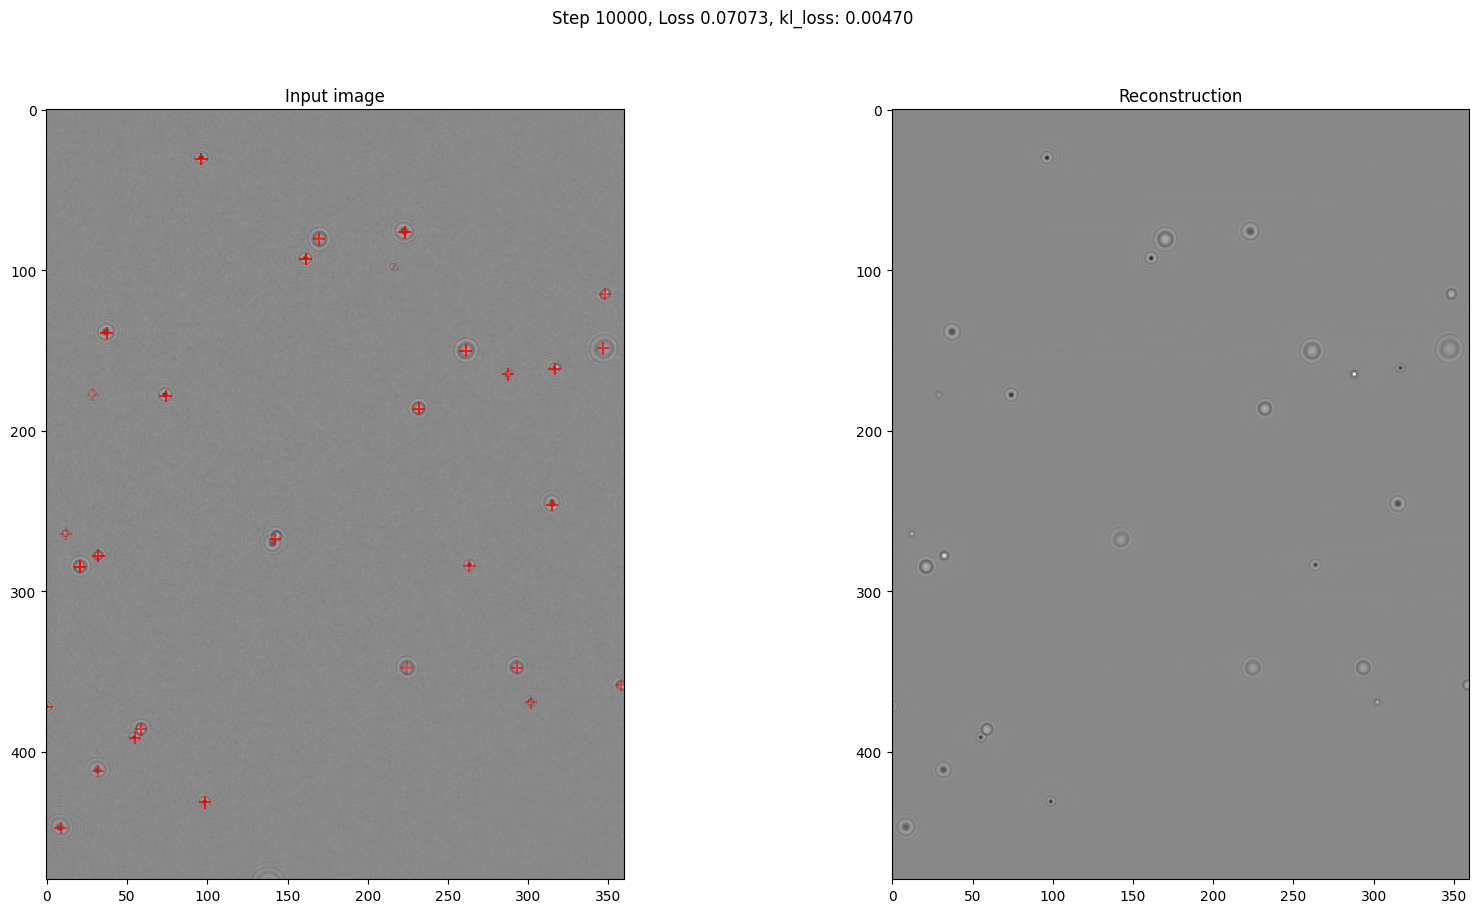

`Trainer.fit` stopped: `max_steps=10000` reached.


NameError: name 'test_loader' is not defined

In [7]:
# anneal beta from 1e-10 to 1e-8 over 150 epochs
import numpy as np
import IPython.display as ipd
import pytorch_lightning as pl
import optuna

max_steps = 10000

beta_annealing_end = 1200
lr_annealing_end = max_steps
kl_annealing_end = 2400

class PlottingCallback(pl.Callback):


    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:

        ipd.clear_output(wait=True)
        loss = trainer.callback_metrics["loss_epoch"]
        kl = trainer.callback_metrics["kl_epoch"]
        plot(model, train_loader)
        plt.suptitle(f"Step {trainer.global_step}, Loss {loss:.5f}, kl_loss: {kl:.5f}")

        plt.show()

        
def beta_annealing(step):
    logs = np.logspace(-4.5, -2, beta_annealing_end)
    if step >= beta_annealing_end:
        return logs[-1]
    else:
        return logs[int(step)]

def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < 500:
        return 0

    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]
    
class Annealing(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        step = trainer.global_step
        
        pl_module.beta = beta_annealing(step)
        pl_module.fg_model.kl_importance = kl_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)

trainer = pl.Trainer(
    gpus=1,
    max_steps=max_steps,
    callbacks=[PlottingCallback(), Annealing()],
    logger=False,
#     check_val_every_n_epoch=1000,
)

# model.fg_model.topk_select_method = "random"
trainer.fit(model, train_loader)

# evaluate
test_results = trainer.test(model, test_loader)


In [ ]:
def plot(model, test_loader):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    recon, presence, bg, fg, xy, z_bg, kl_bg, kl_fg = model(x)
    
    
    print(presence)
#     xy = xy.view(1, -1, x.shape[2], x.shape[3])
    alpha = presence.detach().cpu().numpy()
    xy = xy.detach().cpu().numpy()

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[0, :, 1], xy[0, :, 0], alpha=alpha, marker="+", s=80, c="r")
    
    plt.title("Input image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")

    
plot(model, train_loader)

In [ ]:

image = next(iter(test_loader))[1:2]

xgrid = np.linspace(0, 64, 1024)
ygrid = np.linspace(0, 64, 1024)    
X, Y = np.meshgrid(xgrid, ygrid)

X, Y = torch.tensor(X).float(), torch.tensor(Y).float()

y = model.model.resample(model.model, image, Y, X)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(y[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
plt.colorbar()

